# Setting up

In [3]:
# import math functions
from math import sqrt, exp as mexp

# import numpy functions
from numpy import (
    vectorize, linspace, logspace, arange, zeros, log10, fill_diagonal, 
    exp, pi, set_printoptions, log2, inf, array, ndarray, diagonal,
    cos, sqrt as nsqrt, log, sin, ones, finfo
)
from scipy.sparse import diags as spdiags
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve


import sys

# set to print lines to large width
set_printoptions(linewidth=500)

from itertools import cycle

%matplotlib inline
from matplotlib.style import use
use("seaborn")

# import the default plot settings
from pltconfig import *

# Problem 1

## Part A

In [23]:
class q1a(object):
    
    def __init__(
        self, m=50, t0=0.0, T=2*pi, alpha=0.7, beta=0.7, 
        guess_alternate=0, 
        tol=finfo("float32").eps, max_iter=500
        ):
        
        # assign input variables
        self.m = m
        self.t0 = t0
        self.T = T
        self.alpha = alpha
        self.beta = beta
        self.guess_alternate = guess_alternate
        self.tol = tol
        self.max_iter = max_iter
        
        # compute derived variables
        self.h = (T-t0)/(m+1)
        self.t_pts = t0 + arange(m+2)*self.h
        self.initial_soln = self.get_initial_solution()
        self.soln = zeros(m+2)
        
    def get_initial_solution(self):
        
        """Description: Define what the initial guess \Theta^{[k=0]} is"""
        
        m = self.m
        alpha = self.alpha
        beta = self.beta
        t_pts = self.t_pts
        T = self.T
        
        # initialize the array for the initial guess
        initial_soln = zeros(m+2)
        
        # set the boundary terms
        initial_soln[0] = alpha
        initial_soln[m+1] = beta
        
        # set the guess
        if (self.guess_alternate == 1):
            initial_soln[1:-1] = 0.7 # uniform guess
        elif (self.guess_alternate == 2):
            initial_soln[1:-1] = 0.7 + 1.0*sin(0.5*t_pts[1:-1]) 
        elif (self.guess_alternate == 3):
            initial_soln[1:-1] = alpha*cos(t_pts[1:-1]) + ((beta-alpha*cos(T))/(T*cos(T)))*cos(t_pts[1:-1]) 
        else:
            initial_soln[1:-1] = 0.7*cos(t_pts[1:-1]) + 0.5*sin(t_pts[1:-1]) 
            
        return initial_soln

    def get_Jacobian(self):
        
        m = self.m
        h = self.h
        h_sq = h*h
        curr_soln = self.soln
        
        # define the diagonals
        diagonals = [
            ones(m-1), 
            -2+h*h*cos(curr_soln[1:-1]), 
            ones(m-1)
        ]
        
        # use the diagonal definitions to define the Jacobian matrix
        J = spdiags(diagonals, [-1,0,1]).tolil()
        
        J *= (1./(h_sq))

        return J.tocsr() # ensure that matrix returned is efficient for computation
    
    def get_G(self):
        
        m = self.m
        h = self.h
        h_sq = h*h
        curr_soln = self.soln
        
        # initialize the G function
        G = zeros(m+2)
        
        # fix the boundary conditions
        G[0] = curr_soln[0]
        G[-1] = curr_soln[-1]
        
        # evaluate G at the interior points
        G[1:-1] = (
            (1./h_sq)*(curr_soln[2:]-2*curr_soln[1:-1]+curr_soln[:-2]) 
            + sin(curr_soln[1:-1])
        )
        
        return G[1:-1] # only internal pts matter for the computation
    
    def run_iteration(self):
        
        m = self.m
        
        # set the standard tolerance
        tolerance = self.tol
        # define maximum iteration to prevent infinite loop
        max_iteration = self.max_iter
        iteration = 0
        
        delta = ones(m)
        
        # initialize the solution with initial guess
        self.soln[...] = self.initial_soln[...]
        
        # check for the infinity norm of the update
        while ((delta.__abs__().max() > tolerance) and (iteration < max_iteration)):
            
            delta = spsolve(self.get_Jacobian(), -self.get_G())
            
            # update the solution. Only update interior pts since boundary fixed.
            self.soln[1:-1] = self.soln[1:-1] + delta
            
            # increment iteration counter
            iteration += 1
        
        self.num_iterations = iteration # record how many iterations it took to converge
        self.final_update_norm = delta.__abs__().max() # record the final update inf norm
        
    def get_plot(self, prefix="q1a"):
        
        fig, ax = subplots(1,1, figsize=(10,10))
        
        ax.plot(self.t_pts, self.soln, lw=3.0, color="black", label="Final solution")
        ax.plot(self.t_pts, self.initial_soln, lw=3.0, ls=":", label="Initial guess")
        
        ax.legend(loc=0, prop={"size": 20})
        ax.set_ylabel(r"$\theta(t)$", fontsize=28)
        ax.set_xlabel(r"$t$", fontsize=28)
        ax.tick_params(labelsize=24)
        ax.grid(True)
        
        fig.tight_layout()
        fig.savefig(prefix + "_figure.pdf")
        
    def run_iteration_plot(self, prefix="q1a"):
        
        m = self.m
        
        # set the standard tolerance
        tolerance = self.tol
        # define maximum iteration to prevent infinite loop
        max_iteration = self.max_iter
        iteration = 0
        
        delta = ones(m)
        
        # initialize the solution with initial guess
        self.soln[...] = self.initial_soln[...]
        
        fig, ax = subplots(1,1, figsize=(10,10))
        lines_lst = []; iteration_lst = []
        
        # check for the infinity norm of the update
        while ((delta.__abs__().max() > tolerance) and (iteration < max_iteration)):
            
            delta = spsolve(self.get_Jacobian(), -self.get_G())
            
            # update the solution. Only update interior pts since boundary fixed.
            self.soln[1:-1] = self.soln[1:-1] + delta
            
            # Plot the solution
            lines_lst.append(ax.plot(self.t_pts, self.soln, lw=3.0)[0])
            iteration_lst.append(iteration)
            
            # increment iteration counter
            iteration += 1
        
        self.num_iterations = iteration # record how many iterations it took to converge
        self.final_update_norm = delta.__abs__().max() # record the final update inf norm
        
        leg1 = ax.legend(
            lines_lst, iteration_lst, loc="lower left", prop={"size": 16}, 
            title="Iteration", title_fontsize=18
        )
        
        ax.plot(self.t_pts, self.initial_soln, lw=3.0, ls=":", color="black", label="Initial guess")
        ax.legend(loc="lower right", prop={"size": 20})
        
        ax.add_artist(leg1)
        
        ax.set_ylabel(r"$\theta(t)$", fontsize=28)
        ax.set_xlabel(r"$t$", fontsize=28)
        ax.tick_params(labelsize=24)
        ax.grid(True)
        
        
        fig.tight_layout()
        fig.savefig(prefix + "_iteration_figure.pdf")

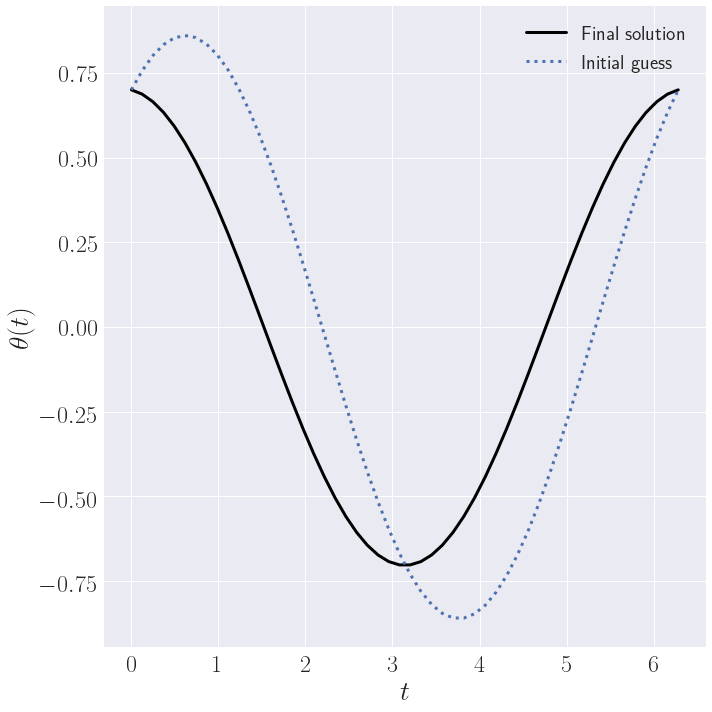

In [27]:
sample_q1a_long = q1a()
sample_q1a_long.run_iteration()
sample_q1a_long.get_plot()

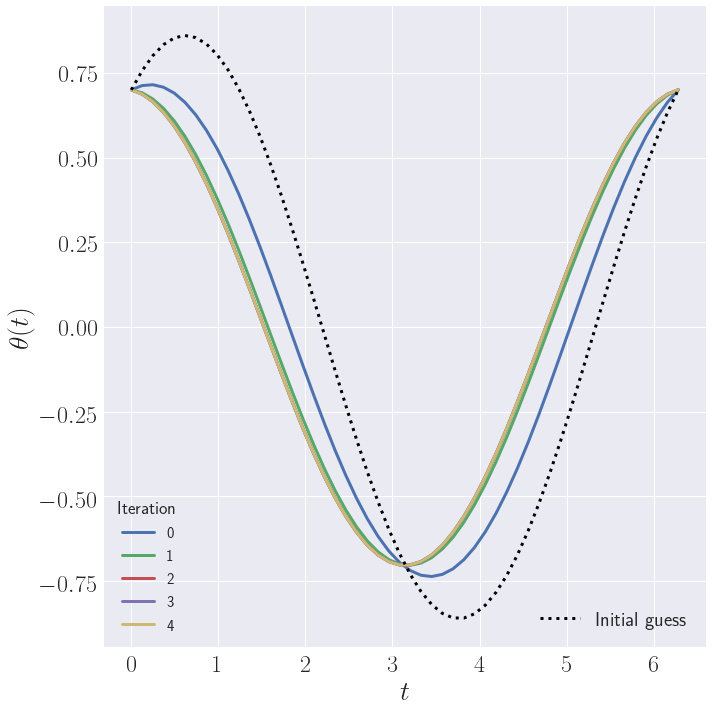

In [4]:
sample_q1a = q1a()
sample_q1a.run_iteration_plot(prefix="q1a_2pt4a")

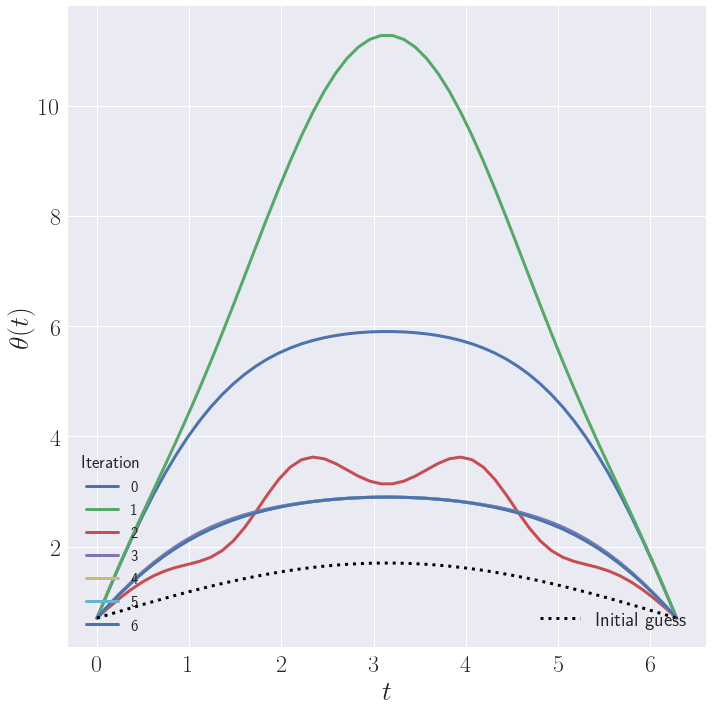

In [5]:
sample_q1a2 = q1a(guess_alternate=2)
sample_q1a2.run_iteration_plot(prefix="q1a_2pt4b")

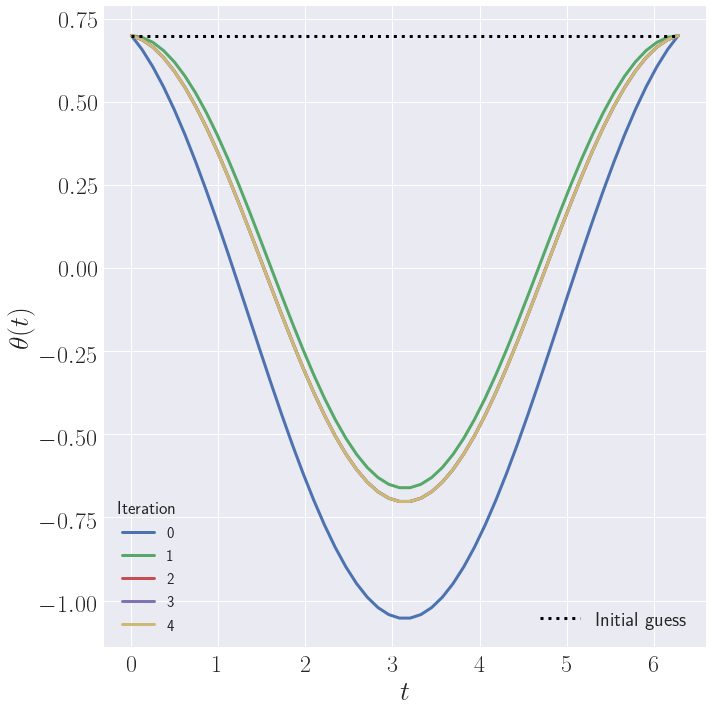

In [6]:
sample_q1a3 = q1a(guess_alternate=1)
sample_q1a3.run_iteration_plot(prefix="q1a_2pt5")

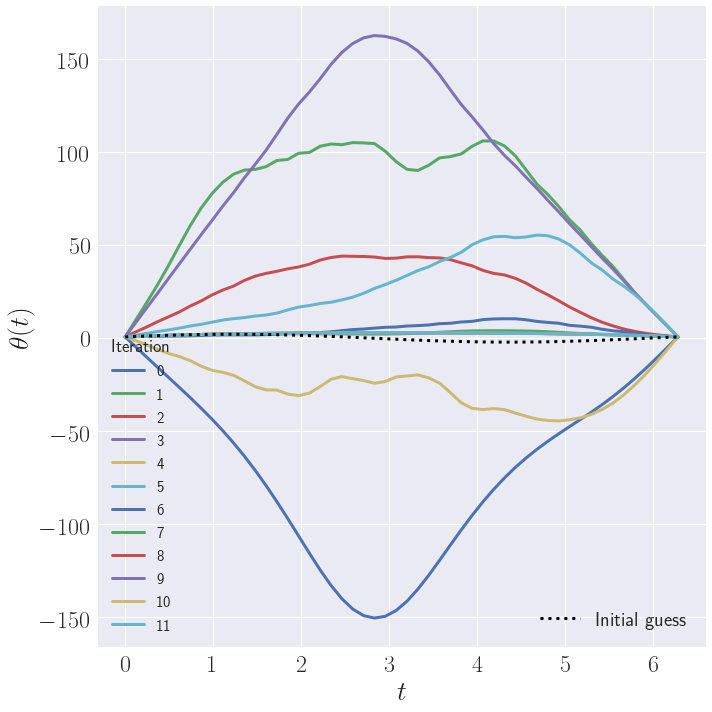

In [13]:
sample_q1a4 = q1a(guess_alternate=3)
sample_q1a4.run_iteration_plot(prefix="q1a_alt_guess")

## Part B

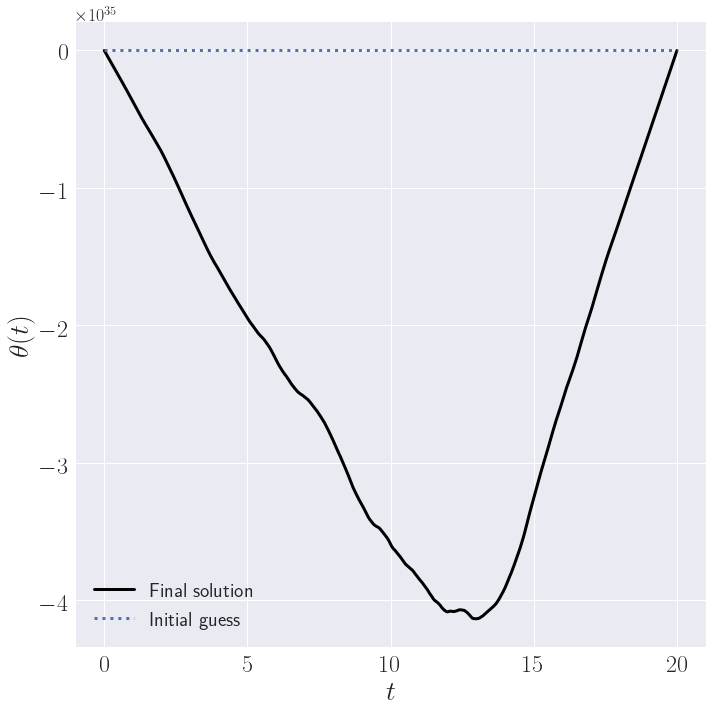

In [12]:
sample_q1b = q1a(m=1000, T=20.0, guess_alternate=1)
sample_q1b.run_iteration()
sample_q1b.get_plot(prefix="q2b_long")

In [5]:
def plot_as_func_of_T(Tmax=20):
    
    num_ms = 4
    Ts = arange(1, Tmax+1)
    max_theta = zeros((num_ms,int(Tmax)))
    Ns_array = zeros(num_ms)
    
    m = 500 # set initial number of internal grid points
    for iteration in range(num_ms):
        for i in range(1,int(Tmax)+1):
            # initialize object
            q1a_obj = q1a(m=m,T=i,guess_alternate=2)
            # run the Newton iteration
            q1a_obj.run_iteration()
            # get the maximum theta
#             print(m, i, q1a_obj.soln.max())
            max_theta[iteration, i-1] = q1a_obj.soln.max()
            # delete object before next iteration
            del q1a_obj
        # record the total number of intervals used
        Ns_array[iteration] = m + 1
        
        # update the number of internal points in the grid
        # such that the number of intervals doubles
        m = 2*m + 1
    
    # prepare the figure
    fig, ax = subplots(1,1, figsize=(10,10))
    for iteration in range(num_ms):
        ax.plot(Ts, max_theta[iteration,:], lw=3.0, label=f"{Ns_array[iteration]:3.0f}")
    ax.set_yscale("log")
    ax.set_ylabel(r"$\max\limits_{i}\ \theta_{i}$", fontsize=28)
    ax.set_xlabel(r"$T$", fontsize=28)
    ax.tick_params(labelsize=24)
    ax.legend(loc=0, prop={"size":18}, title=r"$N$", title_fontsize=28)
    ax.grid(True)
    
    fig.tight_layout()
    fig.savefig("q1b_figure.pdf")